In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import scipy.stats as stats
from urllib.parse import urlencode
from operator import attrgetter
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

**Часть 1. Исследование retention**

Напишем функцию, которая будет считать retention игроков (по дням от даты регистрации игрока) для разных временных периодов. 

Данные имеют следующую структуру:

problem1-reg_data.csv – данные о времени регистрации

problem1-auth_data.csv – данные о времени захода пользователей в игру

In [2]:
def data_preparetion():
    """
    Подготавливаем данные о времени регистрации и авторизации пользователей для дальнейшего анализа
    """
    
    # Часть 1: импорт, проверка, очистка и подготовка данных

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    name_dict = {'reg_data': 'https://disk.yandex.ru/d/moV-ZDQQwfbdng',
                 'auth_data': 'https://disk.yandex.ru/d/0XjpypVfP5DkbQ'}
    # получаем загрузочную ссылку
    for key, value in name_dict.items():
        final_url = base_url + urlencode(dict(public_key=value))
        response = requests.get(final_url)
        download_url = response.json()['href']
        # загружаем файл и сохраняем его
        download_response = requests.get(download_url)
        with open(f'{key}.csv', 'wb') as f:   # Здесь укажите нужный путь к файлу
            f.write(download_response.content)

    # импортируем данные о времени регистрации и данные о времени захода пользователей в игру
    auth_data = pd.read_csv('auth_data.csv', sep=';')
    reg_data = pd.read_csv('reg_data.csv', sep=';')

    # проверяем наличие обязательных колонок и выводим возможные ошибки
    required_reg_cols = ['reg_ts', 'uid']
    required_auth_cols = ['auth_ts', 'uid']

    for col in required_reg_cols:
        if col not in reg_data.columns:
            raise ValueError(f"В reg_data отсутствует колонка {col}")

    for col in required_auth_cols:
        if col not in auth_data.columns:
            raise ValueError(f"В auth_data отсутствует колонка {col}")

    # оцениваем размер данных
    print("Размер данных:")
    print(f"Регистрации: {reg_data.shape}, Авторизации: {auth_data.shape}")

    # удаляем строки с пропусками в ключевых колонках, если они есть
    reg_data_clean = reg_data.dropna(subset=['uid', 'reg_ts']).copy()
    auth_data_clean = auth_data.dropna(subset=['uid', 'auth_ts']).copy()

    print(f"\nПосле удаления пропусков:")
    print(f"Регистрации: {reg_data_clean.shape}, Авторизации: {auth_data_clean.shape}")

    # проверяем пропущенные значения
    print("\nПропущенные значения в reg_data:")
    print(reg_data_clean.isnull().sum())
    print("\nПропущенные значения в auth_data:")
    print(auth_data_clean.isnull().sum())

    # проверяем дубликаты
    print(f"\nДубликаты в reg_data: {reg_data_clean.duplicated().sum()}")
    print(f"Дубликаты в auth_data: {auth_data_clean.duplicated().sum()}")

    # удаляем полные дубликаты, если они есть
    reg_data_clean = reg_data_clean.drop_duplicates()
    auth_data_clean = auth_data_clean.drop_duplicates()

    print("Дубликаты удалены")

    # проверяем дубликаты по user_id в reg_data
    # (у одного пользователя не может быть несколько дат регистрации)
    reg_duplicates = reg_data_clean['uid'].duplicated().sum()
    print(f"Пользователей с повторной регистрацией: {reg_duplicates}")

    if reg_duplicates > 0:
        print("Обрабатываем дубликаты регистраций...")
    # оставляем первую регистрацию для каждого пользователя
        reg_data_clean = reg_data_clean.sort_values('reg_ts').drop_duplicates('user_id', keep='first')

    # преобразуем timestamp в дату
    reg_data_clean['reg_date'] = pd.to_datetime(reg_data_clean['reg_ts'], unit='s').dt.date
    auth_data_clean['auth_date'] = pd.to_datetime(auth_data_clean['auth_ts'], unit='s').dt.date

    # Часть 2: объединяем таблицы и выполняем проверку данных на адекватность
    # проверяем, что все даты регистрации не позже дат авторизации
    # (пользователь не может зайти ДО регистрации)
    merged_data = auth_data_clean.merge(reg_data_clean[['uid', 'reg_date']], on='uid', how='inner')
    merged_data.drop('auth_ts', axis=1, inplace=True)
    invalid_dates = merged_data[merged_data['auth_date'] < merged_data['reg_date']]
    print(f"\nНайдено записей с авторизацией ДО регистрации: {len(invalid_dates)}")

    print(f"\nПодготовка данных завершена. Размер итоговой таблицы: {merged_data.shape}")
    
    return merged_data

In [3]:
merged_data = data_preparetion()

Размер данных:
Регистрации: (1000000, 2), Авторизации: (9601013, 2)

После удаления пропусков:
Регистрации: (1000000, 2), Авторизации: (9601013, 2)

Пропущенные значения в reg_data:
reg_ts    0
uid       0
dtype: int64

Пропущенные значения в auth_data:
auth_ts    0
uid        0
dtype: int64

Дубликаты в reg_data: 0
Дубликаты в auth_data: 0
Дубликаты удалены
Пользователей с повторной регистрацией: 0

Найдено записей с авторизацией ДО регистрации: 0

Подготовка данных завершена. Размер итоговой таблицы: (9601013, 3)


In [4]:
merged_data.head()

,uid,auth_date,reg_date
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-25,1999-07-22
3,2,1999-07-31,1999-07-22
4,2,1999-08-05,1999-07-22


In [5]:
def calculate_retention_by_day(df = merged_data, year = 2020, month = 3, n_days=14):
    """
    Считает retention по дням от даты регистрации на протяжении 14 дней (двухнедельный ретеншн) с разбивкой на когорты по годам.
    Parameters:
    df - объединенный DataFrame с данными регистрации и авторизации
    year - год, для которого мы хотим посчитать ретеншн, по умолчанию 2021
    month - месяц, для которого мы хотим посчитать ретеншн, по умолчанию 3
    n_days - количество дней для анализа ретеншена (по умолчанию 14)
    """
    
    df = df.copy()

        
    # преобразуем даты в datetime, если они еще не в этом формате
    df['reg_date'] = pd.to_datetime(df['reg_date'])
    df['auth_date'] = pd.to_datetime(df['auth_date'])
    
    # добавляем год регистрации для группировки по когортам
    df['reg_year'] = df['reg_date'].dt.year
    
    # добавляем месяц регистрации для группировки по когортам
    df['reg_month'] = df['reg_date'].dt.month
   
    # вычисляем разницу в днях
    df['day'] = (df['auth_date'] - df['reg_date']).dt.days
       
    # оставляем только визиты в первые n_days и в нужный год и месяц
    df = df[df['day'] <= n_days]
    df = df[df['reg_year'] == year]
    df = df[df['reg_month'] == month]
    
    # убираем дубликаты визитов в один день
    cohort_data = df[['uid', 'reg_date', 'day']].drop_duplicates()
    
    # считаем размер когорт по дням
    cohort_sizes = df.groupby('reg_date')['uid'].nunique()
    
    # создаем таблицу retention
    retention_pivot = pd.crosstab(
        index=cohort_data['reg_date'],
        columns=cohort_data['day'],
        values=cohort_data['uid'],
        aggfunc='count'
    ).fillna(0)
    
    # сортируем колонки по порядку
    retention_pivot = retention_pivot.reindex(columns=sorted(retention_pivot.columns))
    
    # нормализуем по размеру когорты
    retention_rates = retention_pivot.div(cohort_sizes, axis=0)
    
    # округляем для красоты
    retention_rates = retention_rates.round(4)
    
    # строим тепловую карту когортного анализа
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True,
                               gridspec_kw={'width_ratios': [1, 11]})
   
    # тепловая карта для коэффициентов удержания
    retention_rates.index = retention_rates.index.strftime('%d %b %Y')
    cohort_sizes.index = cohort_sizes.index.strftime('%d %b %Y')
    sns.heatmap(retention_rates,
                mask=retention_rates.isnull(),
                annot=True,
                fmt='.1%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title(f'Дневной retention в дневных когортах за {month} месяц {year} года', fontsize=20)

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_sizes)
    cohort_size_df.columns = ['']
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])
    ax[0].set_title('Размер когорты', fontsize=12)
    ax[1].set_xlabel('Дни после регистрации', fontsize=16)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('День регистрации')
    fig.tight_layout()
    plt.show()
    
    print(f"\nРасчет завершен. Размер итоговой таблицы: {retention_rates.shape}")
    return retention_rates

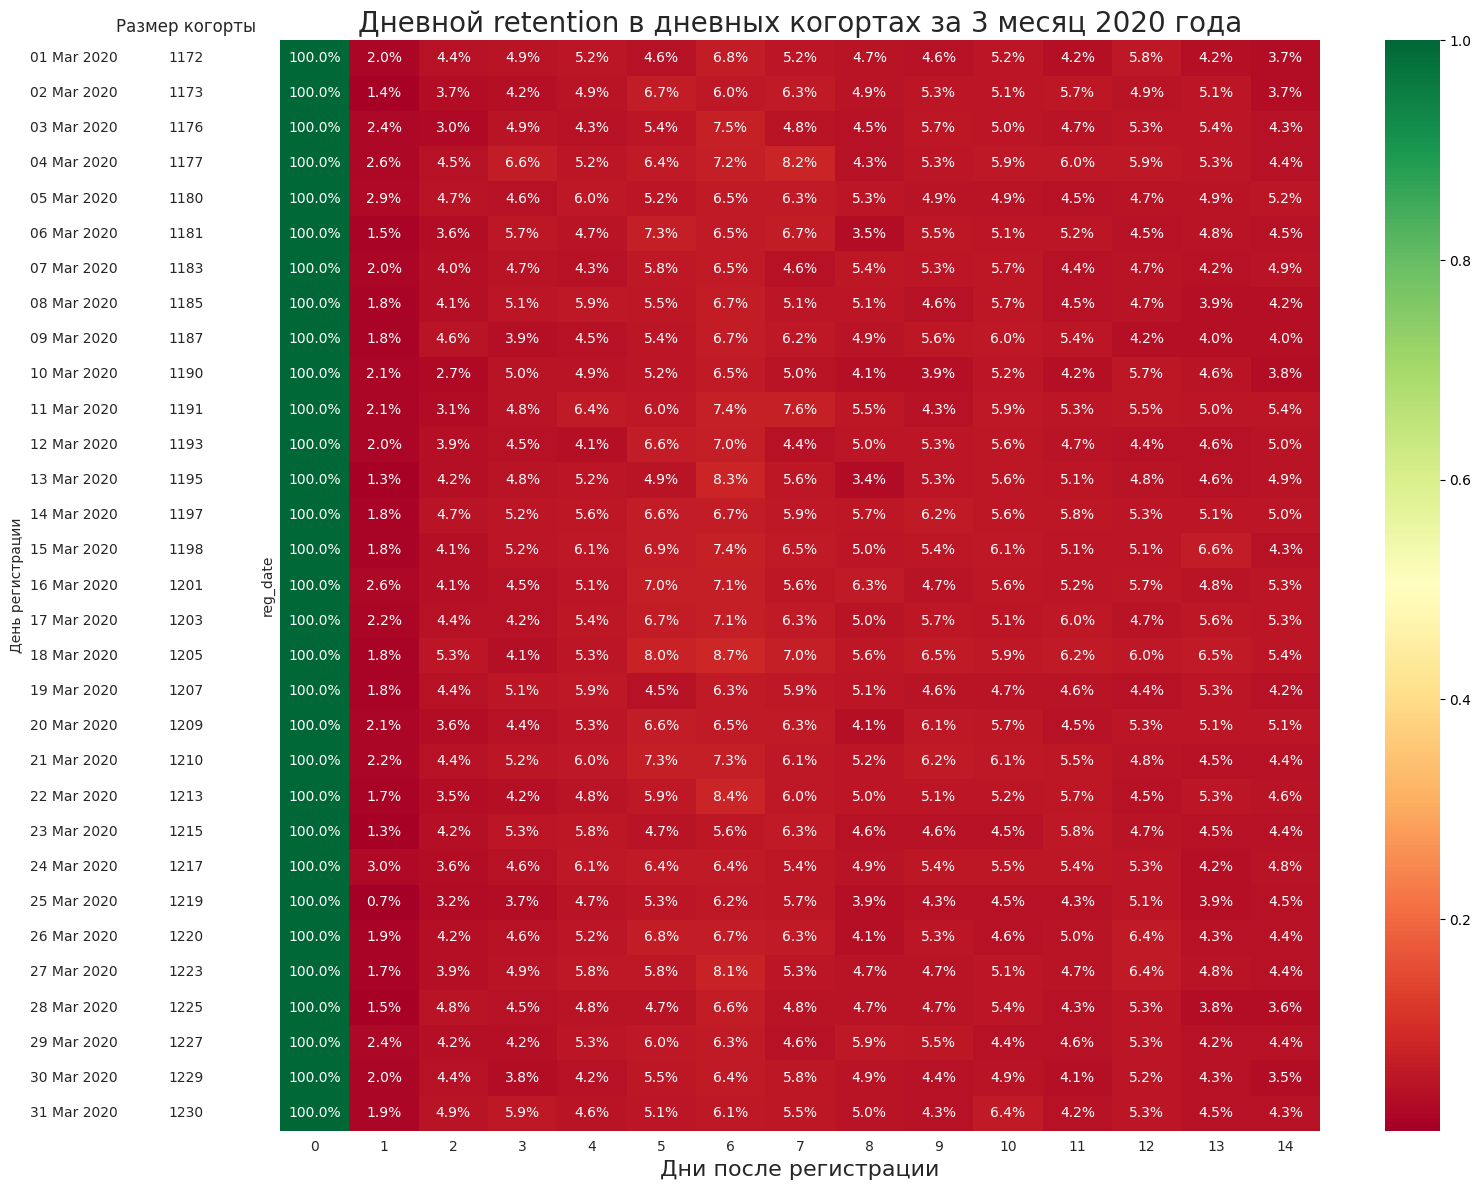


Расчет завершен. Размер итоговой таблицы: (31, 15)


day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_date,,,,,,,,,,,,,,,
01 Mar 2020,1.0,0.0196,0.0444,0.0486,0.0520,0.0461,0.0683,0.0520,0.0469,0.0461,0.0520,0.0418,0.0580,0.0418,0.0367
02 Mar 2020,1.0,0.0136,0.0367,0.0418,0.0494,0.0673,0.0605,0.0631,0.0486,0.0529,0.0512,0.0571,0.0494,0.0512,0.0367
03 Mar 2020,1.0,0.0238,0.0298,0.0485,0.0434,0.0536,0.0748,0.0476,0.0451,0.0570,0.0502,0.0468,0.0527,0.0536,0.0434
04 Mar 2020,1.0,0.0263,0.0450,0.0663,0.0518,0.0637,0.0722,0.0816,0.0433,0.0535,0.0586,0.0603,0.0595,0.0535,0.0442
05 Mar 2020,1.0,0.0288,0.0466,0.0458,0.0602,0.0517,0.0653,0.0627,0.0534,0.0492,0.0492,0.0449,0.0466,0.0492,0.0517
06 Mar 2020,1.0,0.0152,0.0356,0.0567,0.0466,0.0728,0.0652,0.0669,0.0347,0.0550,0.0508,0.0517,0.0449,0.0483,0.0449
07 Mar 2020,1.0,0.0203,0.0397,0.0473,0.0431,0.0583,0.0651,0.0456,0.0541,0.0533,0.0566,0.0440,0.0465,0.0423,0.0490
08 Mar 2020,1.0,0.0177,0.0414,0.0506,0.0591,0.0549,0.0667,0.0515,0.0515,0.0456,0.0574,0.0447,0.0473,0.0388,0.0422
09 Mar 2020,1.0,0.0185,0.0463,0.0388,0.0447,0.0539,0.0666,0.0615,0.0489,0.0564,0.0598,0.0539,0.0421,0.0404,0.0404


In [6]:
calculate_retention_by_day()

## Вывод
Достаточно низкий ретеншн для мобильной игры (как правило, retention на 14-й день считается хорошим, если составляет от 15% до 20% и выше), необходимо работать над product-market-fit.
    

**Часть 2. Анализ А/В-теста**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Проанализируем, какой набор предложений можно считать лучшим и какие метрики стоит проанализировать для принятия правильного решения.

In [7]:
# импорт данных
# скачиваем данные по ссылке из yandex.disk и сохраняем в файле Project_2.csv
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url = 'https://disk.yandex.ru/d/e7OPvKwU2We7FQ'
final_url = base_url + urlencode(dict(public_key=url))
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('Project_2.csv', 'wb') as f:
    f.write(download_response.content)
# создадим датафрейм 
df = pd.read_csv('Project_2.csv', sep=';')

# разделяем пользователей на контрольную и тестовую группы
control_group = df[df['testgroup'] == 'a']  # контроль
test_group = df[df['testgroup'] == 'b']    # тест

# Основные метрики
def calculate_metrics(group, group_name):
    paying_users = group[group['revenue'] > 0]
    conversion = len(paying_users) / len(group) * 100
    arpu = group['revenue'].mean()
    arppu = paying_users['revenue'].mean() if len(paying_users) > 0 else 0
    
    print(f"\n{group_name}:")
    print(f"  Всего пользователей: {len(group):,}")
    print(f"  Платящие пользователи: {len(paying_users):,}")
    print(f"  Конверсия: {conversion:.2f}%")
    print(f"  ARPU: {arpu:.2f}")
    print(f"  ARPPU: {arppu:.2f}")
    
    return conversion, arpu, arppu

conv_control, arpu_control, arppu_control = calculate_metrics(control_group, "Контрольная группа")
conv_test, arpu_test, arppu_test = calculate_metrics(test_group, "Тестовая группа")

# Сравнение
print(f"\n--- СРАВНЕНИЕ с контрольной группой ---")
print(f"Разница в конверсии: {conv_test - conv_control:.4f}% (относительно: {(conv_test/conv_control-1)*100:.2f}%)")
print(f"Разница в ARPU: {arpu_test - arpu_control:.4f} (относительно: {(arpu_test/arpu_control-1)*100:.2f}%)")
print(f"Разница в ARPPU: {arppu_test - arppu_control:.4f} (относительно: {(arppu_test/arppu_control-1)*100:.2f}%)")


Контрольная группа:
  Всего пользователей: 202,103
  Платящие пользователи: 1,928
  Конверсия: 0.95%
  ARPU: 25.41
  ARPPU: 2664.00

Тестовая группа:
  Всего пользователей: 202,667
  Платящие пользователи: 1,805
  Конверсия: 0.89%
  ARPU: 26.75
  ARPPU: 3003.66

--- СРАВНЕНИЕ с контрольной группой ---
Разница в конверсии: -0.0633% (относительно: -6.64%)
Разница в ARPU: 1.3376 (относительно: 5.26%)
Разница в ARPPU: 339.6597 (относительно: 12.75%)


### Промежуточный вывод
Без анализа статистической значимости можно сделать вывод, что в тестовой группе при меньшей на 7% конверсии в платящих пользователей, наблюдается рост ARPPU и ARPU, так как те, кто платят - платят больше. 
Однако необходим анализ статистической значимости для вывода из данных. 

In [8]:
print("ДЕТАЛЬНАЯ СТАТИСТИКА ПО ВЫРУЧКЕ")

def detailed_stats(group, group_name, revenue_col='revenue'):
    """Выводит детальную статистику по выручке для группы"""
    print(f"\n📊 {group_name}:")
    print(f"   Размер группы: {len(group):,} пользователей")
    
    # Базовая статистика
    print(f"   Среднее (ARPU): {group[revenue_col].mean():.2f}")
    print(f"   Медиана: {group[revenue_col].median():.2f}")
    print(f"   Стандартное отклонение: {group[revenue_col].std():.2f}")
    
    # Статистика по нулевым значениям
    zero_count = (group[revenue_col] == 0).sum()
    zero_percent = zero_count / len(group) * 100
    print(f"   Нулевые значения: {zero_count:,} ({zero_percent:.2f}%)")
    
    return group[revenue_col].describe()

control_stats_all = detailed_stats(control_group, "КОНТРОЛЬНАЯ ГРУППА")
test_stats_all = detailed_stats(test_group, "ТЕСТОВАЯ ГРУППА")

# Статистика для платящих пользователей

paying_control = control_group[control_group['revenue'] > 0].reset_index(drop=True)
paying_test = test_group[test_group['revenue'] > 0].reset_index(drop=True)

control_stats_paying = detailed_stats(paying_control, "КОНТРОЛЬНАЯ ГРУППА (платящие)")
test_stats_paying = detailed_stats(paying_test, "ТЕСТОВАЯ ГРУППА (платящие)")

ДЕТАЛЬНАЯ СТАТИСТИКА ПО ВЫРУЧКЕ

📊 КОНТРОЛЬНАЯ ГРУППА:
   Размер группы: 202,103 пользователей
   Среднее (ARPU): 25.41
   Медиана: 0.00
   Стандартное отклонение: 920.77
   Нулевые значения: 200,175 (99.05%)

📊 ТЕСТОВАЯ ГРУППА:
   Размер группы: 202,667 пользователей
   Среднее (ARPU): 26.75
   Медиана: 0.00
   Стандартное отклонение: 287.32
   Нулевые значения: 200,862 (99.11%)

📊 КОНТРОЛЬНАЯ ГРУППА (платящие):
   Размер группы: 1,928 пользователей
   Среднее (ARPU): 2664.00
   Медиана: 311.00
   Стандартное отклонение: 9049.04
   Нулевые значения: 0 (0.00%)

📊 ТЕСТОВАЯ ГРУППА (платящие):
   Размер группы: 1,805 пользователей
   Среднее (ARPU): 3003.66
   Медиана: 3022.00
   Стандартное отклонение: 572.62
   Нулевые значения: 0 (0.00%)


### Визуализируем данные

C:\Users\8asha\AppData\Local\Temp\ipykernel_6120\2790693318.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[1,1].boxplot([paying_control['revenue'], paying_test['revenue']],


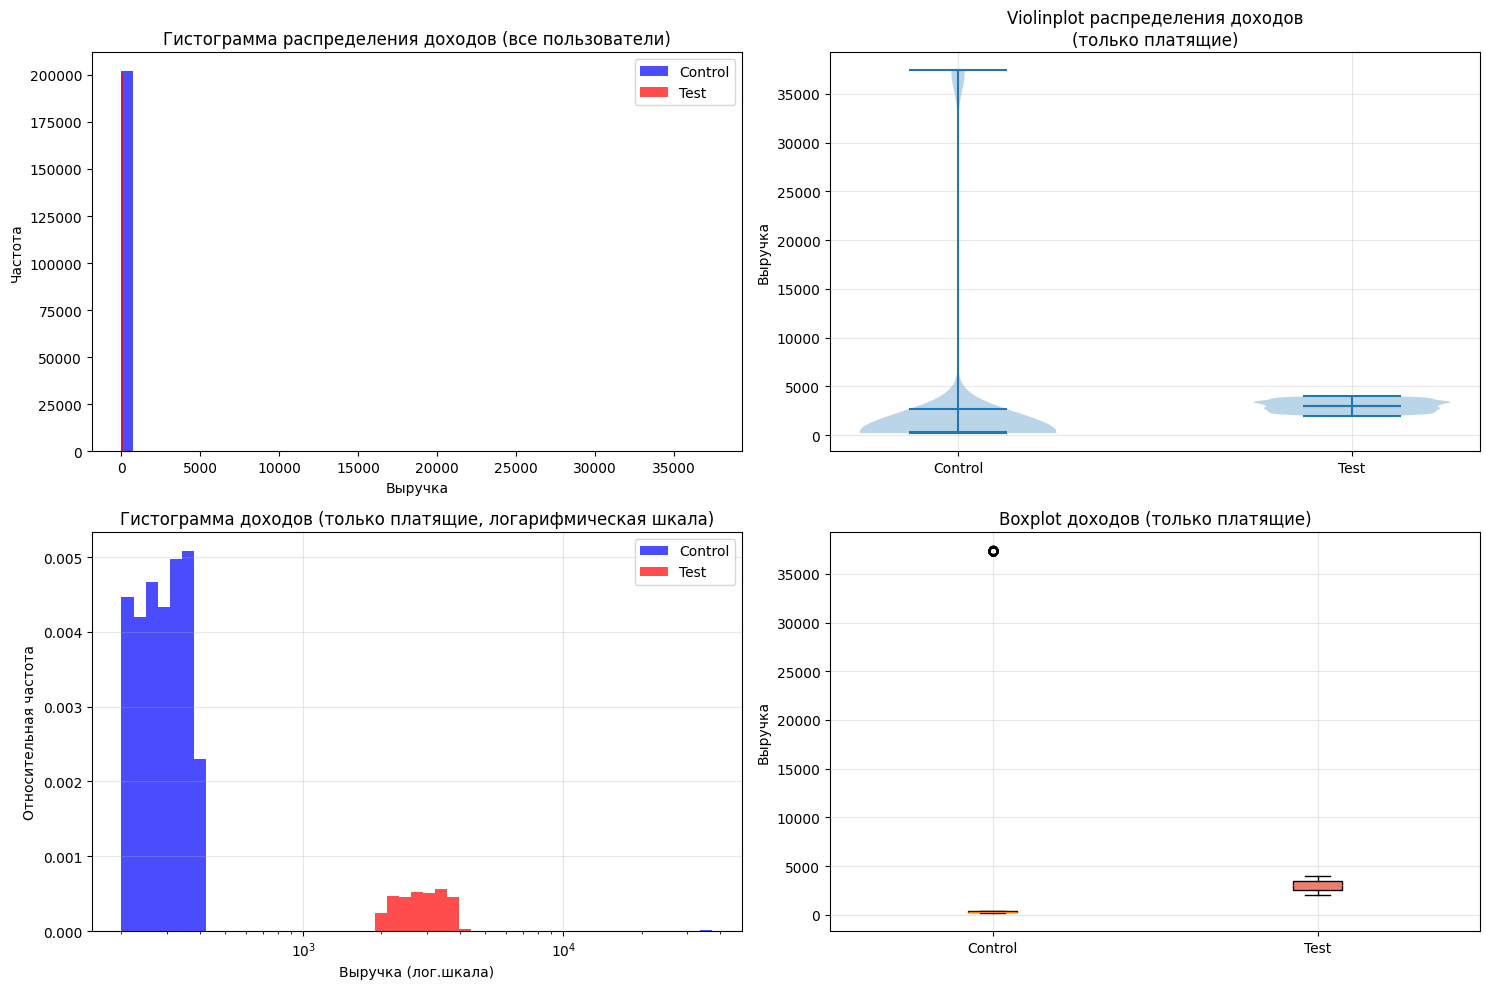

In [9]:
# Графики распределения доходов
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Гистограмма для всех пользователей
axes[0,0].hist(control_group['revenue'], bins=50, alpha=0.7, label='Control', color='blue')
axes[0,0].hist(test_group['revenue'], bins=50, alpha=0.7, label='Test', color='red')
axes[0,0].set_title('Гистограмма распределения доходов (все пользователи)')
axes[0,0].set_xlabel('Выручка')
axes[0,0].set_ylabel('Частота')
axes[0,0].legend()

# 2. Гистограмма для всех пользователей (логарифмическая шкала для лучшей визуализации)
# Фильтруем нулевые значения для логарифмической шкалы
control_nonzero = control_group[control_group['revenue'] > 0]['revenue']
test_nonzero = test_group[test_group['revenue'] > 0]['revenue']

if len(control_nonzero) > 0 and len(test_nonzero) > 0:
    # Используем логарифмические бины для лучшего отображения
    log_bins = np.logspace(np.log10(max(1, min(control_nonzero.min(), test_nonzero.min()))), 
                          np.log10(max(control_nonzero.max(), test_nonzero.max())), 50)
    
    axes[1,0].hist(control_nonzero, bins=log_bins, alpha=0.7, label='Control', color='blue', density=True)
    axes[1,0].hist(test_nonzero, bins=log_bins, alpha=0.7, label='Test', color='red', density=True)
    axes[1,0].set_xscale('log')
    axes[1,0].set_title('Гистограмма доходов (только платящие, логарифмическая шкала)')
    axes[1,0].set_xlabel('Выручка (лог.шкала)')
    axes[1,0].set_ylabel('Относительная частота')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# 3. Violinplot для платящих пользователей
if len(paying_control) > 0 and len(paying_test) > 0:
    violin_parts2 = axes[0,1].violinplot([paying_control['revenue'], paying_test['revenue']], 
                                        showmeans=True, showmedians=True)
    axes[0,1].set_title('Violinplot распределения доходов\n(только платящие)', fontsize=12)
    axes[0,1].set_xticks([1, 2])
    axes[0,1].set_xticklabels(['Control', 'Test'])
    axes[0,1].set_ylabel('Выручка')
    axes[0,1].grid(True, alpha=0.3)

# 4. Boxplot для платящих пользователей 
if len(paying_control) > 0 and len(paying_test) > 0:
    box_plot = axes[1,1].boxplot([paying_control['revenue'], paying_test['revenue']], 
                                labels=['Control', 'Test'], patch_artist=True)
    
    # Раскрашиваем boxplot
    colors = ['lightblue', 'lightcoral']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[1,1].set_title('Boxplot доходов (только платящие)')
    axes[1,1].set_ylabel('Выручка')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Промежуточный вывод
Как можно увидеть из графика, в контрольной группе распределение выручки имеет выраженную правую ассиметрию, полимодальность и редкие крупные платежи, которые можно назвать выбросами, но нельзя исключать из данных при анализе, т.к. это характерно для таких метрик как доход и объясняется поведением пользователей.
В тестовой же группе платящие пользователи приносят более предсказеумую прибыль в диапазоне 2000-4000.

Выбор методов статистического анализа:
* **Конверсия**

Это бинарная метрика - платил/не платил. Для таких метрик часто используется Z-тест.

* **ARPU/ARPPU**

Доход - непрерывная метрика с асимметричным распределением: много нулей (неплатящие) и экстремальные выбросы (крупные платежи). Несмотря на это, у нас большая выборка (>30), поэтому мы можем использовать t-test даже без выполнения требований о нормальности распределения. Проведем тест на равенство дисперсий.

In [10]:
# Тест на равенство дисперсий (Левена) для APRU
stat_var, p_var = stats.levene(control_group['revenue'], test_group['revenue'])
print(f"\nТест Левена на равенство дисперсий: p-value = {p_var:.10f}")

# Критерий для выбора теста
alpha = 0.05
if p_var < alpha:
    print("Дисперсии значимо различаются: используем t-test Уэлча")
else:
    print("Дисперсии не различаются: используем стандартный t-test")


Тест Левена на равенство дисперсий: p-value = 0.5324948591
Дисперсии не различаются: используем стандартный t-test


In [11]:
print("СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ARPU")

# T-test для ARPU
t_stat_arpu, p_value_arpu = stats.ttest_ind(
    test_group['revenue'], 
    control_group['revenue'], 
    equal_var=True  # используем результат теста Левена, что дисперсии равны
)

print(f"t-статистика: {t_stat_arpu:.4f}")
print(f"p-value: {p_value_arpu:.10f}")

СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ARPU
t-статистика: 0.6242
p-value: 0.5324948590


### Промежуточный вывод

p-value > 0.05, Н0 не отклоняется. Статистически значимых различий в APRU нет.

In [12]:
# Тест на равенство дисперсий (Левена) для APРRU
stat_var, p_var = stats.levene(control_group['revenue']>0, test_group['revenue']>0)
print(f"\nТест Левена на равенство дисперсий: p-value = {p_var:.10f}")

# Критерий для выбора теста
alpha = 0.05
if p_var < alpha:
    print("Дисперсии значимо различаются: используем t-test Уэлча")
else:
    print("Дисперсии не различаются: используем стандартный t-test")


Тест Левена на равенство дисперсий: p-value = 0.0350285873
Дисперсии значимо различаются: используем t-test Уэлча


In [13]:
print("СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ARPPU")


# T-test для ARPPU
t_stat_arppu, p_value_arppu = stats.ttest_ind(
    paying_test['revenue'], 
    paying_control['revenue'], 
    equal_var=False
)

print(f"t-статистика: {t_stat_arppu:.4f}")
print(f"p-value: {p_value_arppu:.10f}")

СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ ARPPU
t-статистика: 1.6446
p-value: 0.1002078040


### Промежуточный вывод

p-value > 0.05, Н0 не отклоняется. Статистически значимых различий в ARPPU нет.

In [14]:
print("СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ КОНВЕРСИИ")

# Подсчет платящих пользователей
paying_control_count = len(control_group[control_group['revenue'] > 0])
paying_test_count = len(test_group[test_group['revenue'] > 0])
total_control = len(control_group)
total_test = len(test_group)

print(f"Контроль: {paying_control_count}/{total_control} ({paying_control_count/total_control*100:.4f}%)")
print(f"Тест: {paying_test_count}/{total_test} ({paying_test_count/total_test*100:.4f}%)")

# Z-test для пропорций
count = [paying_test_count, paying_control_count]  # тест, затем контроль
nobs = [total_test, total_control]
z_stat, p_value_conv = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value_conv:.10f}")

СТАТИСТИЧЕСКАЯ ЗНАЧИМОСТЬ КОНВЕРСИИ
Контроль: 1928/202103 (0.9540%)
Тест: 1805/202667 (0.8906%)
Z-статистика: -2.1080
p-value: 0.0350285246


### Промежуточный вывод

p-value < 0.05, Н0 отклоняется. Статистически значимые различия в конверсии есть.
Новое предложение отпугивает часть пользователей от совершения покупок

# Итоговый вывод 
Мы проанализировали конверсию в платящего, APRU и APRRU. 

📊 СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ РАЗЛИЧИЯ:
  - конверсия в платящего: НИЖЕ
  
  
📊 СТАТИСТИЧЕСКИ НЕЗНАЧИМЫЕ РАЗЛИЧИЯ:
  - ARPU
  - ARPPU

### Таким образом, тестовый набор НЕ показывает значимого улучшения основных метрик, стоит оставить оставить предыдущий пакет предложений.

Что делать дальше?

1) проанализировать мощность теста;
2) рассмотреть другие метрики - retention, LTV, отток, распределение платежей по сегментам, поведение пользователей;
3) провести интервью с пользователями;
4) провести А/В тест с другими предложениями.

**Часть 3. Выбор ключевых метрик для мобильной игры**

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Наиболее значимые метрики:**

*North star metric*: среднее время, проведенное в событии на игрока.

Метрики, непосредственно влиящие на NSM (следим в первую очередь):
* ретеншн внутри события
* количество сессий на пользователя
* длительность игровых сессий

Метрики участия:
* MAU/DAU
* Event participation rate
* Распределение игроков по уровням/средний прогресс по уровням
* Churn rate

Метрики монетизации:
* Conversion tate
* ARPU/ARPPU
* LTV
* CPA
* ROI

Другие метрики:
* NPS/CSAT
* Complection rate

После введения механики жестких откатов также дополнительно следим за:
* Hard Drop-off
* частота откатов на игрока
* количество попыток прохождения уровня
* скорость восстаноовления прогресса

# Подробное описание метрик

### Часть 1: Метрики для оценки стандартного тематического события

**1. Метрики участия и охвата:**

* Уникальные участники (Unique Participants): общее количество игроков, которые запустили
  событие хотя бы один раз. Показывает общий интерес.

* Участие игроков в событии (Event Participation Rate): доля игроков, запустивших событие, от общего числа активных игроков за период события (MAU или DAU). Говорит о привлекательности темы и эффективности анонсов.

* Активность в первый день (Day 1 Engagement): количество игроков, которые приняли участие в событии в первые 24 часа после его старта. Оценка успешности маркетинга в рекламе события.

* CPA (стоимость привлечения клиента) в событие: затраты на рекламу или маркетинг, делённые на число новых пользователей, привлечённых в результате этой рекламы или маркетинговой кампании.

**2. Метрики вовлеченности и прогресса:**
   
* Коэффициент завершения (Completion Rate): процент игроков от общего числа участников, дошедших до финала и получили главную награду. Это ключевая метрика успеха события. 
*Можно разбить на "общий CR" (от всех, кто начал) и "CR от достигших середины"*

* Распределение игроков по уровням: график в виде гистограммы распределения игроков по уровням. Помогает определить уровни, на которых из-за сложности "отваливалось" наибольшее количество игроков и перебалансировать эти уровни.

* Количество попыток на уровень: точечно выявляет самые сложные уровни, т.н. "бутылочные горлышки".

* Среднее время, проведенное в событии на игрока: показывает глубину вовлечения.

* Ретеншн внутри события (Intra-Event Retention): процент игроков, которые возвращались в событие в течение периода события.

* Частота использования механик: статистику по использованию бустов, пропусков и других механик внутри события.

* Количество сессий на пользователя: сколько раз в день игроки запускают игру.  

* Churn Rate (Коэффициент оттока): показывает процент игроков, которые перестают играть в игру через определённое время.

**3. Метрики монетизации и эффективности:**

* Конверсия в покупку (Conversion Rate to Purchase): процент участников, которые совершили покупку внутри события (например, за кристаллы/валюту для продолжения игры, специальные бустеры).
  
* Доход на платящего игрока (ARPPU): средняя выручка с платящего игрока в рамках события.

* Доход на игрока (ARPU): средняя выручка с игрока в рамках события. 

* LTV на событие: общая сумма дохода, которую приносит один игрок за всё время взаимодействия с событием.

* Общий доход от события (Total Event Revenue): абсолютная сумма денег, заработанная за время проведения события. 

* Распределение покупок по типам: если игроки часто покупают "пропуск уровня" на определенном уровне, это возможно также сигнал к перебалансировке этого уровня.

* ROI (Return on Investment) события: ключевая бизнес-метрика. Оценка окупаемости затрат на разработку и проведение события.
*Формула: (Доход от события - Затраты на событие) / Затраты на событие * 100%*


**4. Метрики удовлетворенности:**

* Опрос игроков после события: короткий опрос, появляющийся после завершения или выхода из события. Шкала оценки, опрос и возможность оставить отзыв в произвольной форме.
** NPS (Net Promoter Score) — "Насколько вы вероятно порекомендуете это событие другу?"
** CSAT (Customer Satisfaction) — "Насколько вы довольны событием?".
  
* Удержание после события (Post-Event Retention): процент участников события, которые продолжают играть в основную игру через 1, 3 и 7 дней после окончания события.

* Анализ тональности упоминаний (Sentiment Analysis): отзывы в магазинах приложений, форумы, Discord, Telegram, соцсети.

* User-Generated Content (UGC): подсчет количества фанатских мемов, гайдов, артов, связанных с событием

* Процент шеринга (Share Rate): сколько игроков поделились своими достижениями (например, скриншотом финальной награды) через встроенную функцию шеринга в соцсети.

# Как изменятся метрики при введении новой механики

### Часть 2: Изменение метрик при введении механики отката
Так как новая механика радикально меняет игровой опыт, делая его более жестким, акцент смещается с "дошел ли игрок до конца" на "как игрок справляется с трудностями и риском". Все прежние метрики остаются (но произойдет изменение в интерпретации некоторых существующих метрик), но также мы добавляем ещё несколько метрик, чтобы оценить отток игроков после введения новой механики.

***Новые метрики:***

**Метрики, связанные непосредственно с откатом:**

* Средняя глубина отката игрока: на сколько уровней в среднем откатывается игрок за все свои неудачи.
  
* Частота откатов на игрока: как часто игрок сталкивается с неудачей, ведущей к откату.

* Процент игроков, не восстановивших прогресс после отката (Hard Drop-off): если игрок откатился и больше не делал попыток — механика его сломала.

* Скорость восстановления прогресса: как быстро игроки возвращаются на тот уровень, где их "откатило". Если скорость высокая, игроки не теряют мотивацию.

* "Точки невозврата": уровни, после неудачи на которых игроки чаще всего бросают событие. Это критически важные данные для балансировки.

* Метрика поведения и стратегии: игроки начнут использовать защитные или "страховочные" бусты чаще, чем атакующие.

***Изменение в интерпретации уже существующих метрик:***

Метрики вовлеченности:
* Коэффициент завершения (Completion Rate) резко упадет. Теперь это метрика, показывающая процент самых упорных и/или самых платящих игроков. 

* Среднее количество попыток прохождения уровня: теперь нужно различать "первые попытки" и "повторные попытки после отката".

* Ретеншн внутри события (Intra-Event Retention): теперь должен оцениваться не только по дням, но и по попыткам/откатам в событии. Т.е. нужно оценировать, возвращались ли игроки после первого и последующих откатов.

Метрики монетизации:
* Доход с "пострадавших" игроков: сравнение ARPPU у игроков без откатов, с 1-2 откатами и с 3+ откатами. Вероятно, игроки, столкнувшиеся с откатами, будут приносить значительно больше.

* Конверсия в покупку (Conversion Rate to Purchase): игроки, столкнувшись с риском потери прогресса, возможно будут покупать бустеры, внутриигровые предметы, увеличивающие шанс пройти уровень.
Можно ввести "конверсию в опции спасения": частота покупок отмены отката (если такая механика будет введена) в разбивке по уровням и количеству откатов.